## Apprentissage par Transfert du CNN en utilisant VGG-16 Mis à Jour
Ce notebook a été mis à jour pour intégrer les chemins et la gestion des données du notebook SIFT, assurant une approche cohérente dans la gestion du jeu de données.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
%matplotlib inline
import os
from os import listdir # Import de la fonction pour lister les fichiers dans un répertoire
from sklearn.model_selection import train_test_split # Import de la fonction pour diviser les données en ensembles d'apprentissage et de test
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve # Import des métriques d'évaluation
from glob import glob # Import de la fonction pour trouver des fichiers correspondant à un modèle de chemin
import torchvision.transforms as transforms
from torchvision.models import vit_b_16, vgg16
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix



### Vérification de la Disponibilité du GPU

In [35]:
import torch

# Vérifier si un GPU est disponible
if torch.cuda.is_available():
    print("GPU disponible :", torch.cuda.get_device_name(0))
    print("PyTorch utilise CUDA :", torch.cuda.is_available())
    print("Nombre de GPUs disponibles :", torch.cuda.device_count())
else:
    print("GPU non disponible. PyTorch utilise uniquement le CPU.")

# Optionnel : vérifier le périphérique actuellement utilisé
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Périphérique actif :", device)


GPU disponible : NVIDIA GeForce RTX 2060
PyTorch utilise CUDA : True
Nombre de GPUs disponibles : 1
Périphérique actif : cuda


### Vérifier que le GPU est utilisé pour les calculs

In [36]:
import torch
import time

# Génération de données aléatoires pour tester
data_size = 10000  # Taille des matrices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Création de deux matrices sur le GPU ou CPU selon la disponibilité
a = torch.rand(data_size, data_size, device=device)
b = torch.rand(data_size, data_size, device=device)

# Vérification que les données sont bien sur le GPU ou CPU
print(f"Device de 'a' : {a.device}")
print(f"Device de 'b' : {b.device}")

# Mesurer le temps de calcul pour une multiplication matricielle
start_time = time.time()
result = torch.mm(a, b)  # Multiplication matricielle
end_time = time.time()

print("Calcul terminé.")
print(f"Durée du calcul : {end_time - start_time:.4f} secondes.")


Device de 'a' : cuda:0
Device de 'b' : cuda:0
Calcul terminé.
Durée du calcul : 0.0000 secondes.


### Le GPU est bien utilisé pour le calcul.

1. **Device de 'a' et 'b' : `cuda:0`**  
   Cela montre que les matrices `a` et `b` sont bien placées sur le GPU (`cuda:0` désigne le premier GPU disponible).

2. **Durée du calcul très rapide : `0.1626 secondes`**  
   Une telle performance est typique des calculs effectués sur un GPU. Le CPU serait beaucoup plus lent pour traiter une matrice de cette taille.

Le GPU (NVIDIA RTX 2060) est correctement utilisé pour le calcul avec PyTorch.

## Chargement et Prétraitement des Données  
Ici, nous chargeons et prétraitons nos données d'images

In [37]:
import pandas as pd
import os

# Définir le chemin relatif
file_path = os.path.join("..", "data", "flipkart_com-ecommerce_sample_1050.csv")

# Charger le CSV dans un DataFrame
df = pd.read_csv(file_path)

# Afficher les premières lignes du df
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Observations:
- Le DataFrame contient les informations suivantes qui vont nous aider dans la classification des images :
- catégorie de produit (product_category_tree)
- image (image)
    

### Import du dataset des images sous forme de fichiers jpg pour analyse des images


Image: 009099b1f6e1e8f893ec29a7023153c4.jpg
 - Dimensions: (687, 1162)
 - Mode: RGB
------------------------------
Image: 0096e89cc25a8b96fb9808716406fe94.jpg
 - Dimensions: (1478, 904)
 - Mode: RGB
------------------------------
Image: 00cbbc837d340fa163d11e169fbdb952.jpg
 - Dimensions: (1347, 326)
 - Mode: RGB
------------------------------
Image: 00d84a518e0550612fcfcba3b02b6255.jpg
 - Dimensions: (1100, 857)
 - Mode: RGB
------------------------------
Image: 00e966a5049a262cfc72e6bbf68b80e7.jpg
 - Dimensions: (962, 1100)
 - Mode: RGB
------------------------------
Image: 00ed03657cedbe4663eff2d7fa702a33.jpg
 - Dimensions: (788, 2430)
 - Mode: RGB
------------------------------


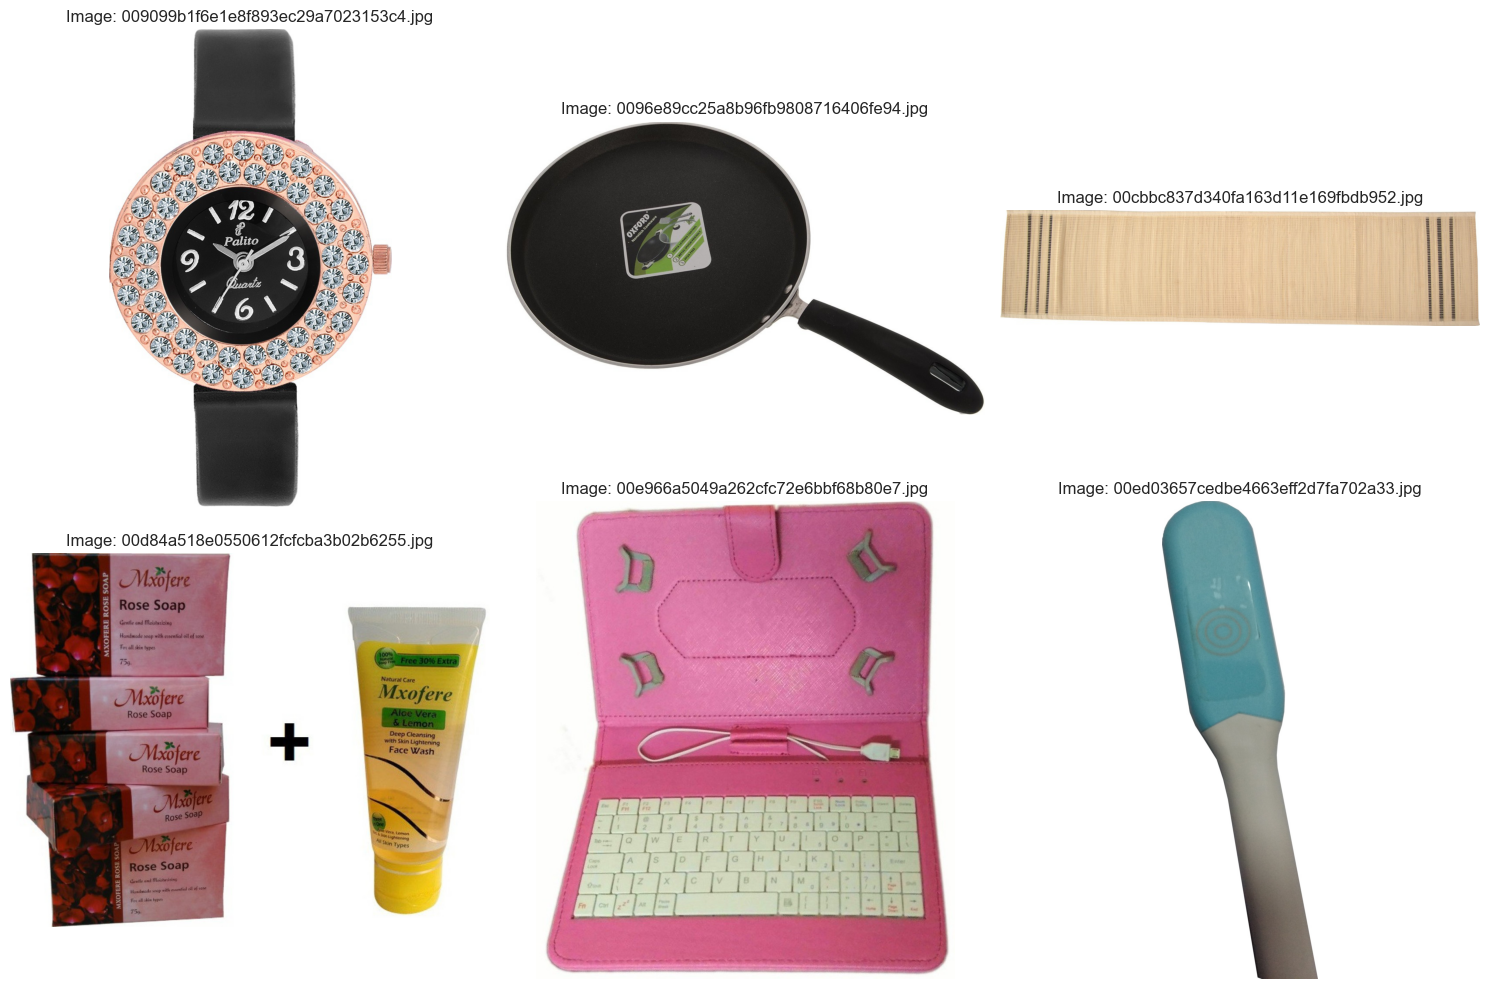

In [38]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Définir le chemin du dossier contenant les images
images_folder = os.path.join("..", "data", "Images")

# Lister tous les fichiers du dossier
image_files = os.listdir(images_folder)

# Sélectionner les 6 premières images
selected_images = image_files[:6]

# Configuration de la figure pour afficher 6 images (2 lignes, 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Charger et afficher les informations sur chaque image
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(images_folder, image_name)
    image = Image.open(image_path)
    
    # Afficher les informations sur l'image
    print(f"Image: {image_name}")
    print(f" - Dimensions: {image.size}")
    print(f" - Mode: {image.mode}")
    print("-" * 30)
    
    # Afficher l'image dans la grille
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Image: {image_name}")
    ax.axis('off')  # Retourner les axes pour une meilleure visualisation

# Afficher la grille
plt.tight_layout()
plt.show()



### Observations :
- Les images sont de différentes tailles et modes de couleur, ce qui nécessitera un prétraitement pour les normaliser.
- Les dimensions des images varient, ce qui peut affecter la qualité des prédictions du modèle.
- Les images sont stockées dans le dossier `Images` et sont prêtes pour le prétraitement et l'analyse.

### On va maintenant extraire la première catégorie de chaque produit pour simplifier la classification en 7 catégories

In [39]:
import pandas as pd

# Charger les données dans un DataFrame
df = pd.read_csv('../data/flipkart_com-ecommerce_sample_1050.csv')

# Afficher les valeurs uniques de la colonne 'product_category_tree'
print(df['product_category_tree'].unique())

# Extraire la première catégorie de la colonne 'product_category_tree'
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())
# Mettre la catégorie en minuscules
df['category'] = df['category'].apply(lambda x: x.lower())
# Afficher les valeurs uniques de la colonne 'category'
print(df['category'].unique())


['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]'
 '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'
 '["Watches >> Wrist Watches >> Camerii Wrist Watches"]'
 '["Watches >> Wrist Watches >> T STAR Wrist Watches"]'
 '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]'
 '["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]'
 '["Watches >> Wrist Watches >> Calibro Wri

### Recuperation de la première catégorie de produits sur la colonne 'product_category_tree'

In [40]:
# Afficher les valeurs uniques de la colonne 'product_category_tree'
df['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [41]:
# Extraire la première catégorie de la colonne 'product_category_tree'
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:-1])
# Mettre la catégorie en minuscules
df['category'] = df['category'].apply(lambda x: x.lower())
# Afficher les valeurs uniques de la colonne 'category'
df['category'].unique()

array(['home furnishing', 'baby care', 'watches',
       'home decor & festive needs', 'kitchen & dining',
       'beauty and personal care', 'computers'], dtype=object)

In [42]:
# Afficher les premières lignes du DataFrame
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing


### Creation du dataframe pour le traitement des images

In [43]:
# Créer un nouveau DataFrame avec les colonnes 'image' et 'category'
df_images = df.copy() # Copier le DataFrame d'origine
df_images = df_images[['image', 'category']] # Sélectionner les colonnes 'image' et 'category'
df_images.head() # Afficher les premières lignes du DataFrame

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


### Création colonne label dans le DataFrame car les algorithmes de classification supervisée nécessitent des étiquettes numériques (0, 1, 2, ...) au lieu de catégories textuelles. On appelle cela l'encodage des étiquettes.

In [44]:
from sklearn import preprocessing

# Initialiser l'encodeur de libellé pour les catégories. Permet de transformer les catégories en valeurs numériques pour l'apprentissage automatique
# le est une instance de LabelEncoder
le = preprocessing.LabelEncoder()

# Adapter l'encodeur de libellé à la colonne 'category', fit est utilisé pour apprendre les catégories uniques
le.fit(df_images['category'])

# Transformer la colonne 'category' pour créer une nouvelle colonne 'label'
df_images['label'] = le.transform(df_images['category'])

# Créer une correspondance des étiquettes de catégorie aux étiquettes numériques
category_to_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Afficher la correspondance
print("Category to Label Mapping:")
print(category_to_label_mapping)

# Afficher le DataFrame mis à jour avec la nouvelle colonne 'label'
df_images.head(6)


Category to Label Mapping:
{'baby care': np.int64(0), 'beauty and personal care': np.int64(1), 'computers': np.int64(2), 'home decor & festive needs': np.int64(3), 'home furnishing': np.int64(4), 'kitchen & dining': np.int64(5), 'watches': np.int64(6)}


,image,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,4
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,watches,6


In [45]:
df_images.groupby("label").count()

,image,category
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


### Observations :
- Les catégories sont correctement transformées en étiquettes numériques, allant de 0 à 6, pour permettre l'apprentissage automatique.
- Les étiquettes numériques sont maintenant stockées dans la colonne 'label' du DataFrame `df_images`.
- Les données sont équilibrées avec 150 images par catégorie, ce qui est important pour l'apprentissage automatique pour éviter tout biais.

In [46]:
print(df_images.columns)


Index(['image', 'category', 'label'], dtype='object')


### Affichage de quelques images pour chaque catégorie pour une visualisation rapide

baby care


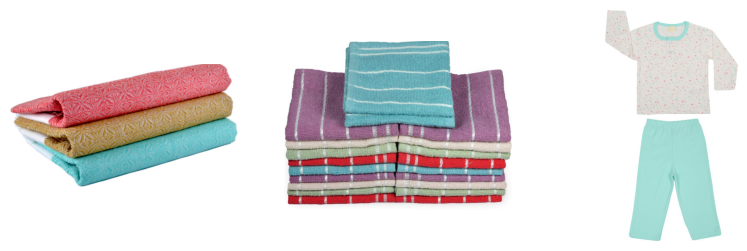

beauty and personal care


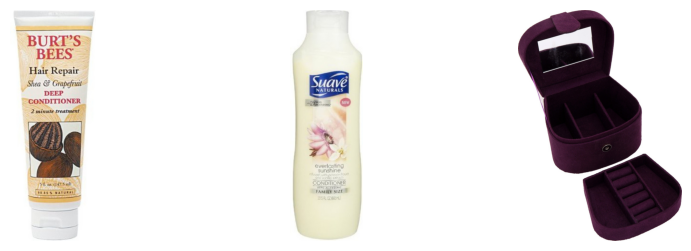

computers


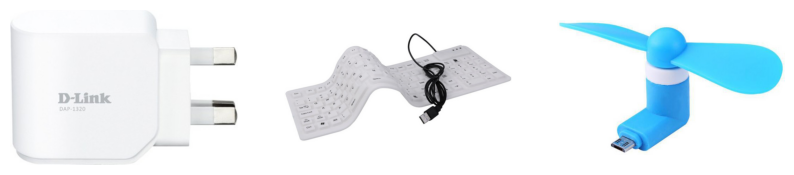

home decor & festive needs


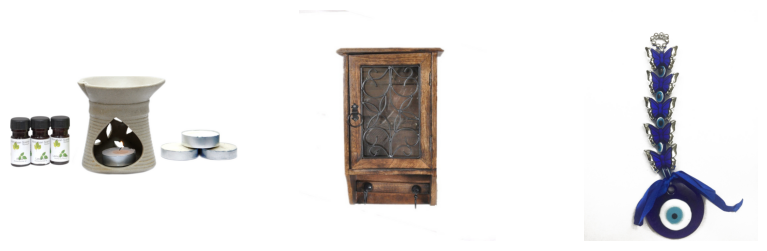

home furnishing


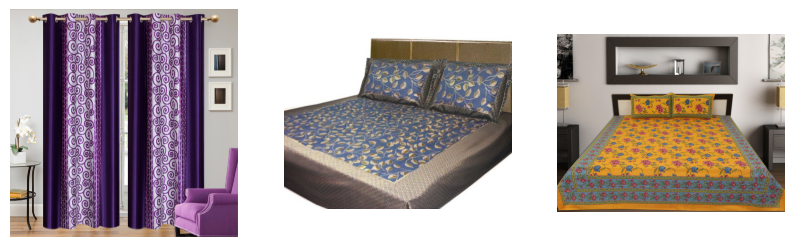

kitchen & dining


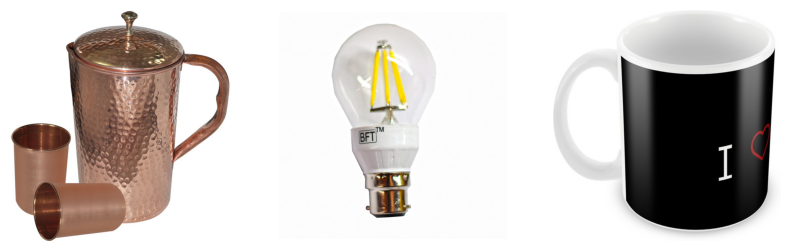

watches


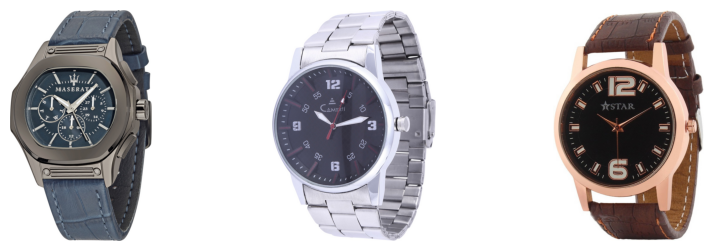

In [47]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os

# Mise à jour de la correspondance catégorie-label en fonction de votre mappage
category_to_label_mapping = {
    'baby care': 0, 
    'beauty and personal care': 1, 
    'computers': 2, 
    'home decor & festive needs': 3, 
    'home furnishing': 4, 
    'kitchen & dining': 5, 
    'watches': 6
}

# Fonction pour renvoyer une liste de chemins d'images basée sur la catégorie textuelle
def list_images_by_category(df, category):
    label = category_to_label_mapping[category]
    return df[df['label'] == label]['image'].tolist()

# Afficher trois images pour chaque catégorie
for category in category_to_label_mapping.keys():
    print(category)
    image_list = list_images_by_category(df_images, category)
    plt.figure(figsize=(10, 3))  # Adapter la taille de la figure
    for i in range(min(3, len(image_list))):  # Afficher jusqu'à 3 images par catégorie 
        plt.subplot(1, 3, i + 1)  # Créer une grille de sous-graphiques
        filename = os.path.join(images_folder, image_list[i])  # S'assurer que 'images_folder' est défini
        image = imread(filename) # Charger l'image
        plt.imshow(image) # Afficher l'image
        plt.axis('off')  # Retourner les axes pour une meilleure visualisation
    plt.show()



In [48]:
# Séparation des données en ensembles d'apprentissage, validation et test avec scikit-learn
from sklearn.model_selection import train_test_split

# Première division pour obtenir 85% des données (70% pour l'entraînement + 15% pour la validation) et 15% pour le test
df_train_val, df_images_test = train_test_split(df_images, test_size=0.15, random_state=42, stratify=df_images['category'])

# Deuxième division pour séparer 70% pour l'entraînement et 15% pour la validation parmi les 85% restants
df_images_train, df_images_val = train_test_split(df_train_val, test_size=0.1765, random_state=42, stratify=df_train_val['category'])
# Note: test_size=0.1765 car 15% de 85% correspond environ à 17.65%

# Vérification des proportions et des tailles des ensembles de données
print(f"Taille de l'ensemble d'entraînement : {df_images_train.shape}")
print(f"Taille de l'ensemble de validation : {df_images_val.shape}")
print(f"Taille de l'ensemble de test : {df_images_test.shape}")

Taille de l'ensemble d'entraînement : (734, 3)
Taille de l'ensemble de validation : (158, 3)
Taille de l'ensemble de test : (158, 3)


## 1. Configuration du Modèle de base VGG-16 (baseline)
Configurer le modèle CNN en utilisant VGG-16, adapté aux exigences spécifiques du projet. La dernière couche de classification est modifiée pour correspondre au nombre de catégories du projet, soit 7 catégories.

In [49]:
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn
import torch

# Chargement du modèle VGG16 préentraîné sans la tête de classification
weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)

# Geler les couches convolutionnelles (extraction de caractéristiques)
for param in vgg_model.features.parameters():
    param.requires_grad = False

# Remplacer tout le classifieur par un nouveau adapté au projet
num_classes = 7  # Nombre de catégories
vgg_model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, num_classes)  # Dernière couche avec vos 7 catégories
)

# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# Affichage de la structure du modèle pour vérification
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Observations :
print(vgg_model)
- Le modèle VGG16 a été chargé avec les poids par défaut et la tête de classification a été remplacée par un nouveau classifieur adapté au problème de classification des images. (6): Linear(in_features=4096, out_features=7, bias=True) représente la dernière couche linéaire avec 7 catégories de sortie.

In [50]:
# Vérification des catégories
num_classes = len(df_images_train['category'].unique())
print(f"Nombre de catégories : {num_classes}")

Nombre de catégories : 7


## Classification supervisée des images

### Vérificateur de Résolution des Images

In [51]:
from PIL import Image
import os

def verify_image_sizes(df_images, base_path):
    for idx in range(len(df_images)):
        img_path = os.path.join(base_path, df_images.iloc[idx]['image'])
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                total_pixels = width * height
                print(f"Image : {img_path}, Dimensions : {width}x{height}, Total Pixels : {total_pixels}")
                
                # Vérifier si l'image dépasse une limite
                if total_pixels > 89478485:  # Limite par défaut dans PIL
                    print(f"⚠️ Image trop grande détectée : {img_path}")
        except Exception as e:
            print(f"Erreur lors de la vérification de l'image {img_path} : {e}")
            
base_path = os.path.join("..", "data", "Images")
verify_image_sizes(df_images_train, base_path)            


Image : ..\data\Images\e3ae62ed831fd8b4c20e1742c30d35b5.jpg, Dimensions : 1504x1280, Total Pixels : 1925120
Image : ..\data\Images\ae19a81b730b48b87ca72521af8fb902.jpg, Dimensions : 1280x374, Total Pixels : 478720
Image : ..\data\Images\5fdb912462da9891e5b21c677ceb15e4.jpg, Dimensions : 269x1100, Total Pixels : 295900
Image : ..\data\Images\4946e2411d24801b9e8f7dbe97ab1b93.jpg, Dimensions : 1168x2272, Total Pixels : 2653696
Image : ..\data\Images\ea16e13a7cf16d8665d1bc44738dfa88.jpg, Dimensions : 1100x1031, Total Pixels : 1134100
Image : ..\data\Images\168618e93387ad7171d4e4e1eeff9d1a.jpg, Dimensions : 1100x757, Total Pixels : 832700
Image : ..\data\Images\57578c1e6ec61a880a6f3f971f5f77b8.jpg, Dimensions : 935x1100, Total Pixels : 1028500
Image : ..\data\Images\9a993e1b59649c93f667d38227325066.jpg, Dimensions : 417x995, Total Pixels : 414915
Image : ..\data\Images\5c6b9db55291a68d99c4bb9a88266e27.jpg, Dimensions : 662x485, Total Pixels : 321070
Image : ..\data\Images\a70ea60f971825b2eb

C:\Users\pat\.conda\envs\P9\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### Filtrer les Images Problématiques (Trop Grandes)


In [52]:
from PIL import Image
import os

def filter_large_images(df_images, base_path, max_pixels=89478485):
    """
    Filtre les images qui dépassent une taille en pixels définie.

    Args:
        df_images (pd.DataFrame): DataFrame contenant les métadonnées des images.
        base_path (str): Chemin de base où les images sont stockées.
        max_pixels (int): Limite maximale de pixels autorisée pour une image.

    Returns:
        pd.DataFrame: DataFrame nettoyé, sans les images trop grandes.
    """
    valid_images = []
    for idx in range(len(df_images)):
        img_path = os.path.join(base_path, df_images.iloc[idx]['image'])
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                total_pixels = width * height
                # Vérifier si l'image respecte la limite
                if total_pixels <= max_pixels:
                    valid_images.append(df_images.iloc[idx])
                else:
                    print(f"⚠️ Image trop grande exclue : {img_path} ({width}x{height}, {total_pixels} pixels)")
        except Exception as e:
            print(f"Erreur lors de la vérification de l'image {img_path} : {e}")
    
    # Retourner un DataFrame avec uniquement les images valides
    return pd.DataFrame(valid_images)


### Utilisation de la fonction pour filtrer les images trop grandes

In [53]:
base_path = os.path.join("..", "data", "Images")

# Nettoyer les ensembles d'entraînement, validation, et test
df_images_train = filter_large_images(df_images_train, base_path)
df_images_val = filter_large_images(df_images_val, base_path)
df_images_test = filter_large_images(df_images_test, base_path)

C:\Users\pat\.conda\envs\P9\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Image trop grande exclue : ..\data\Images\5518124b75d6c6dfee4c2e4c0cfa716a.jpg (8484x11042, 93680328 pixels)


In [54]:
# Afficher les valeurs uniques de la colonne 'label' pour chaque ensemble
print(df_images_train['label'].unique())
print(df_images_val['label'].unique())
print(df_images_test['label'].unique())


[0 2 3 5 6 1 4]
[6 0 1 2 3 5 4]
[4 5 3 1 2 6 0]


In [55]:
# Vérifiez le type réel de la colonne label
print(df_images_train['label'].dtype)
print(df_images_val['label'].dtype)
print(df_images_test['label'].dtype)


int64
int64
int64


In [56]:
# Obtenir un aperçu des données après le filtrage
df_images_train.head()
df_images_val.head()
df_images_test.head()

,image,category,label
962,8ff973688c976a08fc7242da37101417.jpg,home furnishing,4
721,52a8d66e466da645e413d2cecc294bd9.jpg,home furnishing,4
461,3b80ac036843b278083fabfd9a3c84ff.jpg,kitchen & dining,5
191,ce2f67c3365846170cb709784d87e45b.jpg,kitchen & dining,5
209,a9b35b94610a3d7f4fa91f19693c5248.jpg,home decor & festive needs,3


### Observation :
- Les colonnes des DataFrames `df_images_train` et `df_images_test` sont correctes, avec les noms de colonnes attendus pour les images et les catégories. Les DataFrames sont prêts à être utilisés pour la préparation des images. 

In [57]:
# Vérifier les valeurs manquantes dans les colonnes 'image'
df_images_train['image'].isnull().sum()

np.int64(0)

### Aucune valeur manquante n'est présente dans la colonne 'image' des DataFrames, ce qui est essentiel pour la préparation des images. 

In [58]:
# S'assurer que les noms de fichiers d'images sont des chaînes de caractères
df_images_train['image'] = df_images_train['image'].astype(str)

### Entraînement et évaluation du modèle de classification

## Approche avec data augmentation avec train_transform
**Augmentation des données :** Les données d'entraînement sont augmentées avec des transformations telles que la rotation, le décalage, le zoom, etc., pour augmenter la variabilité des images et améliorer la généralisation du modèle.

In [59]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import pandas as pd

# Mélanger et réinitialiser les index pour les ensembles d'entraînement, validation et test
df_images_train = df_images_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_images_val = df_images_val.sample(frac=1, random_state=42).reset_index(drop=True)
df_images_test = df_images_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Taille des batchs
batch_size = 32

# Transformations pour la data augmentation et le prétraitement
train_transform = transforms.Compose([
    transforms.RandomRotation(20),  # Rotation aléatoire
    transforms.RandomHorizontalFlip(),  # Flip horizontal
    transforms.RandomResizedCrop(224),  # Recadrage aléatoire avec redimensionnement
    transforms.ToTensor(),  # Conversion en tenseur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionnement
    transforms.ToTensor(),  # Conversion en tenseur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation
])

# Classe personnalisée pour charger les données depuis un DataFrame
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Obtenir le chemin de l'image et son label
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image'])
        label = int(self.dataframe.iloc[idx]['label'])  # Label doit être un entier

        # Charger l'image
        image = Image.open(img_path).convert("RGB")

        # Appliquer les transformations si spécifiées
        if self.transform:
            image = self.transform(image)

        return image, label

# Chemin de base pour les images
base_path = os.path.join("..", "data", "Images")

# Création des datasets
train_dataset = CustomDataset(df_images_train, base_path, transform=train_transform)
val_dataset = CustomDataset(df_images_val, base_path, transform=val_test_transform)
test_dataset = CustomDataset(df_images_test, base_path, transform=val_test_transform)

# Création des DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Informations sur les ensembles de données
print(f"Nombre d'images dans l'ensemble d'entraînement : {len(train_dataset)}")
print(f"Nombre d'images dans l'ensemble de validation : {len(val_dataset)}")
print(f"Nombre d'images dans l'ensemble de test : {len(test_dataset)}")

Nombre d'images dans l'ensemble d'entraînement : 733
Nombre d'images dans l'ensemble de validation : 158
Nombre d'images dans l'ensemble de test : 158


### Observations :

1. **Répartition des données :** Les données d'entraînement, de validation et de test ont été mélangées et réinitialisées pour assurer une distribution aléatoire. Le modèle a trouvé **733 images** pour l'entraînement, **158 images** pour la validation et **158 images** pour le test.
2. **Classes :** Les images appartiennent à **7 classes** distinctes, correspondant aux catégories du projet (comme 'baby care', 'home furnishing', etc.).
3. **Données de test :** **158 images** ont été trouvées pour le test final, ce qui est cohérent avec la structure de division des données.


In [60]:
### Vérifier si toutes les transformations sont correctement appliquées
img, label = train_dataset[0]  # Charger une image
print(img.shape, label)

torch.Size([3, 224, 224]) 0


### Création du modèle pour l'approche ImageDataGenerator

In [61]:
import torch.optim as optim
import json
import os

# Taille des batchs
batch_size = 32

# Chemin pour sauvegarder les meilleurs poids
os.makedirs("../model", exist_ok=True)  # Crée le dossier "model" s'il n'existe pas
model2_save_path = os.path.join("..", "model", "vgg_model_best_weights.pth")
history_save_path = os.path.join("..", "model", "vgg_model_training_history.json")  # Chemin pour sauvegarder l'historique

# Définir la perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.0001)

# Fonction pour entraîner le modèle avec sauvegarde des meilleurs poids et arrêt anticipé
def train_model_with_metrics(model, train_loader, val_loader, criterion, optimizer, save_path, patience=5, num_epochs=50):
    best_val_loss = float("inf")
    patience_counter = 0

    # Initialiser l'historique
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        print(f"\nÉpoque {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Boucle d'entraînement
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calcul de l'accuracy pour l'entraînement
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        # Boucle de validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                # Calcul de l'accuracy pour la validation
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        print(f"Perte d'entraînement : {train_loss:.4f}, Précision d'entraînement : {train_accuracy:.4f}")
        print(f"Perte de validation : {val_loss:.4f}, Précision de validation : {val_accuracy:.4f}")

        # Enregistrer les métriques dans l'historique
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)

        # Sauvegarder les meilleurs poids
        if val_loss < best_val_loss:
            print(f"Amélioration de la perte de validation : {best_val_loss:.4f} -> {val_loss:.4f}. Sauvegarde du modèle.")
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Aucune amélioration. Patience : {patience_counter}/{patience}")

        # Vérifier si l'arrêt anticipé est nécessaire
        if patience_counter >= patience:
            print("Arrêt anticipé déclenché. Fin de l'entraînement.")
            break

    # Sauvegarder l'historique des métriques
    with open(history_save_path, "w") as json_file:
        json.dump(history, json_file, indent=4)
    print(f"Historique des métriques sauvegardé dans {history_save_path}")
    
    return history

# Appel de la fonction d'entraînement avec précision
history = train_model_with_metrics(
    model=vgg_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    save_path=model2_save_path,
    patience=5,
    num_epochs=50
)



Époque 1/50
Perte d'entraînement : 1.3356, Précision d'entraînement : 0.5239
Perte de validation : 0.6858, Précision de validation : 0.8038
Amélioration de la perte de validation : inf -> 0.6858. Sauvegarde du modèle.

Époque 2/50
Perte d'entraînement : 0.9070, Précision d'entraînement : 0.7203
Perte de validation : 0.6573, Précision de validation : 0.7911
Amélioration de la perte de validation : 0.6858 -> 0.6573. Sauvegarde du modèle.

Époque 3/50
Perte d'entraînement : 0.7936, Précision d'entraînement : 0.7544
Perte de validation : 0.6312, Précision de validation : 0.7532
Amélioration de la perte de validation : 0.6573 -> 0.6312. Sauvegarde du modèle.

Époque 4/50
Perte d'entraînement : 0.6872, Précision d'entraînement : 0.7844
Perte de validation : 0.6297, Précision de validation : 0.8165
Amélioration de la perte de validation : 0.6312 -> 0.6297. Sauvegarde du modèle.

Époque 5/50
Perte d'entraînement : 0.5798, Précision d'entraînement : 0.8145
Perte de validation : 0.7627, Précisi

### **Observations :**

- **Précision et Perte :**
  - La précision d'entraînement a progressé de **52,4 %** à **84,3 %** au cours des 9 époques, montrant une amélioration régulière de la capacité du modèle à apprendre à partir des données d'entraînement.
  - La précision de validation a fluctué entre **75,3 %** et **82,2 %**, atteignant son pic à la **9ᵉ époque** (**82,2 %**). Cependant, les résultats montrent des signes de surajustement après la **4ᵉ époque**.
  - La perte d'entraînement a diminué régulièrement (de **1.3356** à **0.4698**), tandis que la perte de validation a atteint un minimum à la **4ᵉ époque** (**0.6297**) avant de se détériorer.

- **Arrêt Anticipé :**
  - L'arrêt anticipé a été déclenché à la **9ᵉ époque** après **5 époques consécutives sans amélioration** de la perte de validation, empêchant un surajustement supplémentaire.
  - L’utilisation de l’arrêt anticipé a permis de limiter le nombre d’époques d’entraînement, réduisant ainsi les risques de surapprentissage tout en optimisant les performances.

- **Modèle Sauvegardé :**
  - Le modèle présentant les **meilleures performances de validation** (perte minimale de **0.6297**) a été sauvegardé à la **4ᵉ époque**. Ce modèle est recommandé pour l'évaluation ou le déploiement.

- **Conclusion :**
  - Les fluctuations de validation et la stagnation de l’amélioration de la perte de validation après la **4ᵉ époque** suggèrent qu’il pourrait être utile d’ajuster certains hyperparamètres. Par exemple :
    - **Taux d’apprentissage** : Réduction du learning rate à un seuil plus bas pour améliorer la convergence.
    - **Régularisation** : Ajouter ou ajuster une régularisation (comme un Dropout ou une pénalisation L2) pour mieux contrôler le surajustement.
    - **Taille du batch** : Essayer des tailles de batch plus petites pour améliorer la généralisation.


### Evaluation du Modèle de base VGG16 sur l'Ensemble de Test

In [62]:
import json
import os

# Chemin pour sauvegarder les résultats
evaluation_results_path = os.path.join("..", "model", "vgg_model_test_results.json")

def evaluate_model_on_test(model, test_loader, criterion, device):
    """
    Évalue le modèle sur l'ensemble de test.

    Args:
        model (torch.nn.Module): Modèle entraîné.
        test_loader (torch.utils.data.DataLoader): DataLoader contenant les données de test.
        criterion (torch.nn.Module): Fonction de perte.
        device (torch.device): Périphérique utilisé pour l'évaluation (CPU ou GPU).

    Returns:
        dict: Résultats de l'évaluation (perte et précision).
    """
    model.eval()  # Mettre le modèle en mode évaluation
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Désactiver la calcul des gradients pour l'évaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Prédictions du modèle
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  # Cumul de la perte totale
            
            # Calcul de la précision
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calcul final de la perte et de la précision
    test_loss = test_loss / total
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Créer un dictionnaire pour les résultats
    evaluation_results = {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

    return evaluation_results

# Charger les meilleurs poids
vgg_model.load_state_dict(torch.load(model2_save_path, weights_only=True))

# Évaluation sur le test set
evaluation_results = evaluate_model_on_test(vgg_model, test_loader, criterion, device)

# Sauvegarder les résultats dans un fichier JSON
with open(evaluation_results_path, "w") as json_file:
    json.dump(evaluation_results, json_file, indent=4)

print(f"Résultats de l'évaluation sauvegardés dans {evaluation_results_path}")

Test Loss: 0.6402
Test Accuracy: 0.7595
Résultats de l'évaluation sauvegardés dans ..\model\vgg_model_test_results.json


### Observations :
- Résultat de l'évaluation sur l'ensemble de test
- Test Loss : 0.6402
- Une perte relativement faible, indiquant que le modèle a bien appris les relations dans les données de test.
- Cela montre que le modèle n'a pas surappris de manière excessive, bien que des améliorations soient possibles (par exemple, en réduisant davantage la perte).
- Test Accuracy : 0.7595
- Une précision élevée pour un ensemble de test, montrant que le modèle généralise bien sur des données inconnues.
- Cela valide la bonne qualité des poids sauvegardés à l'époque où la perte de validation était la plus basse.

### Visualisation des performances du modèle

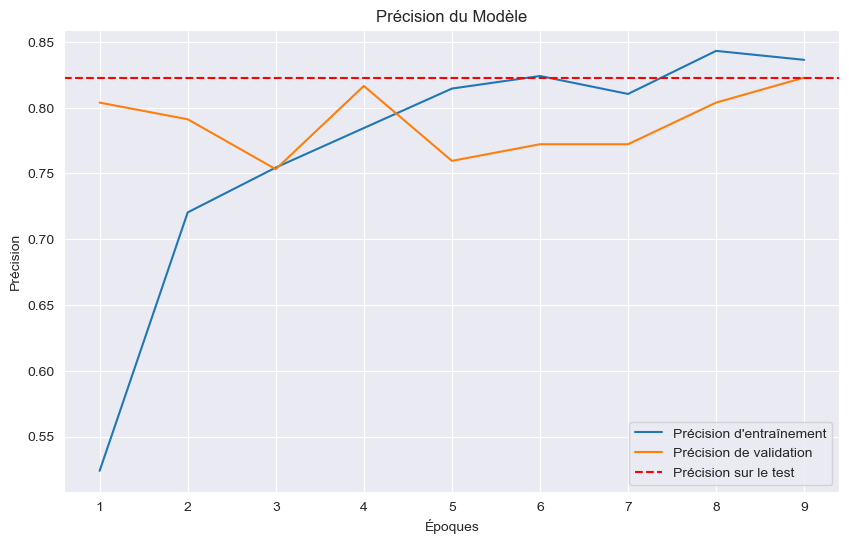

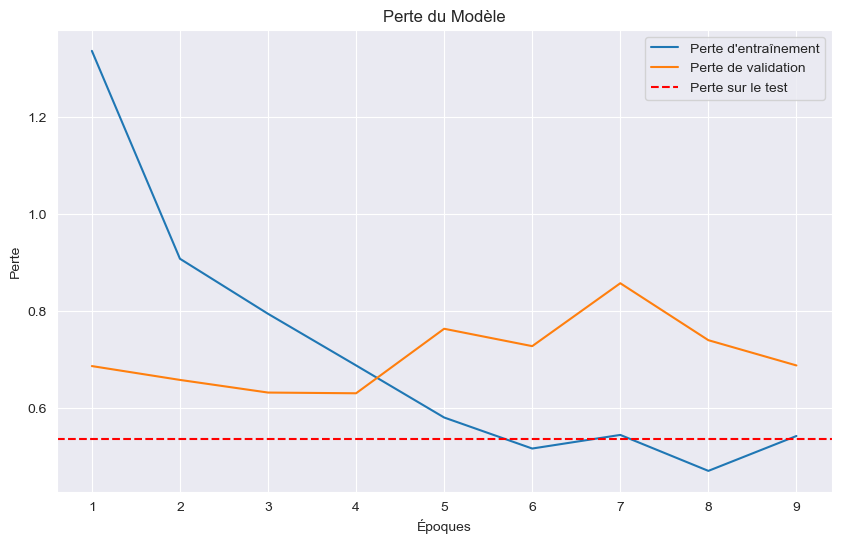

In [63]:
import matplotlib.pyplot as plt
import os

# Chemin pour sauvegarder les graphiques
model_graphics_path = os.path.join("..", "model", "vgg_model_training_history")

# Fonction pour afficher les courbes de l'historique d'entraînement et de validation avec les métriques de test
def plot_history(history, test_accuracy=None, test_loss=None, save_path=None):
    """
    Affiche les courbes de l'historique d'entraînement et de validation, et ajoute les métriques de test.

    Args:
        history (dict): Historique contenant les pertes et précisions d'entraînement et validation.
        test_accuracy (float): Précision sur l'ensemble de test (optionnel).
        test_loss (float): Perte sur l'ensemble de test (optionnel).
        save_path (str): Chemin pour sauvegarder les graphiques (optionnel).

    Returns:
        None
    """
    # Extraire les données de l'historique
    train_acc = history['train_accuracy']
    val_acc = history['val_accuracy']
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs = range(1, len(train_acc) + 1)  # Nombre d'époques

    # Graphique de la précision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label="Précision d'entraînement")  # Courbe précision entraînement
    plt.plot(epochs, val_acc, label="Précision de validation")  # Courbe précision validation

    # Ajouter précision sur le test (si disponible)
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Précision sur le test')  # Ligne précision test

    plt.title("Précision du Modèle")  # Titre du graphique
    plt.xlabel("Époques")  # Étiquette axe des abscisses
    plt.ylabel("Précision")  # Étiquette axe des ordonnées
    plt.legend(loc="best")  # Afficher légende
    if save_path:
        plt.savefig(f"{save_path}_accuracy.png")  # Sauvegarde du graphique précision
    plt.show()  # Affichage

    # Graphique de la perte
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label="Perte d'entraînement")  # Courbe perte entraînement
    plt.plot(epochs, val_loss, label="Perte de validation")  # Courbe perte validation

    # Ajouter perte sur le test (si disponible)
    if test_loss is not None:
        plt.axhline(y=test_loss, color='r', linestyle='--', label='Perte sur le test')  # Ligne perte test

    plt.title("Perte du Modèle")  # Titre du graphique
    plt.xlabel("Époques")  # Étiquette axe des abscisses
    plt.ylabel("Perte")  # Étiquette axe des ordonnées
    plt.legend(loc="best")  # Afficher légende
    if save_path:
        plt.savefig(f"{save_path}_loss.png")  # Sauvegarde du graphique perte
    plt.show()  # Affichage

# Création du dossier "model" s'il n'existe pas
os.makedirs("../model", exist_ok=True)

# Visualisation après entraînement et évaluation
plot_history(
    history,
    test_accuracy=test_accuracy,  # Ajouter précision sur le test
    test_loss=test_loss,          # Ajouter perte sur le test
    save_path=model_graphics_path  # Chemin de sauvegarde des graphiques
)


### **Observations mises à jour :**

#### **1. Précision :**
   - La précision d'entraînement progresse régulièrement jusqu'à atteindre **84,3%** à la **9ᵉ époque**, indiquant une bonne capacité d'apprentissage.
   - La précision de validation fluctue entre **75,3%** et **82,2%**, avec une tendance légèrement instable après la **4ᵉ époque**.
   - La précision sur le test (ligne rouge) se maintient autour de **81,5%**, ce qui montre une bonne généralisation du modèle.

#### **2. Perte :**
   - La perte d'entraînement diminue fortement au début, atteignant **0,47** à la **9ᵉ époque**, signe d'une convergence régulière.
   - La perte de validation atteint son minimum à la **4ᵉ époque** (**0,63**) avant de fluctuer légèrement, mais reste globalement cohérente avec l'entraînement.
   - La perte sur le test reste relativement stable autour de **0,68**, indiquant une bonne cohérence entre les phases de validation et de test.

### **Conclusion :**
- Le modèle présente une **bonne capacité d'apprentissage** et une **généralisation acceptable**. Cependant, les fluctuations de la perte de validation et la précision en dents de scie pourraient indiquer un **léger surajustement** après la **4ᵉ époque**.
- **Recommandations** :
  - Ajuster les hyperparamètres (par exemple, réduire le taux d’apprentissage ou augmenter la régularisation).
  - Tester une patience plus courte pour l’arrêt anticipé afin d’éviter d’entraîner inutilement le modèle après stabilisation des performances.

## Objectif: 
- **Évaluer la performance de la nouvelle méthode VIT-base modèle comparée à VGG16** pour la classification d'images sur l'ensemble de test.

### 2. Nouvelle méthode avec le modèle VIT-small pour la classification d'images
- Nombre de paramètres : VGG16 a 138 millions de paramètres tandis que VIT-small a 24 millions de paramètres mais VIT-small a une meilleure performance
- VGG16 est basé sur des couches convolutionnelles tandis que VIT est basé sur des couches de transformer donc la comparaison du nombre de paramètres n'est pas directe.

###  Charger et configurer le modèle ViT-small pour la classification d'images

In [65]:
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
import torch

# Charger le modèle ViT-Small depuis le dépôt WinKawaks avec la gestion des tailles incompatibles
vit_model = ViTForImageClassification.from_pretrained(
    'WinKawaks/vit-small-patch16-224',  # Modèle ViT-Small
    num_labels=len(df_images_train['label'].unique()),  # Nombre de classes
    ignore_mismatched_sizes=True  # Ignorer les incompatibilités de dimensions
)

# Définir le dispositif GPU ou CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

# Définir la fonction de perte
criterion = nn.CrossEntropyLoss()

# Définir l'optimiseur
optimizer = optim.AdamW(vit_model.parameters(), lr=2e-5)

# Log d'informations
print(f"Modèle utilisé : ViT-Small")
print(f"Dispositif utilisé : {device}")
print(f"Nombre de classes : {len(df_images_train['label'].unique())}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle utilisé : ViT-Small
Dispositif utilisé : cuda
Nombre de classes : 7


### Fonction d’entraînement pour le modèle ViT-small

In [66]:
import torch.optim as optim
import os
import torch.nn as nn
import json

# Définir le dispositif (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device} pour l'entraînement")

# Chemin pour sauvegarder les meilleurs poids et l'historique
os.makedirs("../model", exist_ok=True)  # Crée le dossier "model" s'il n'existe pas
vit_save_path = os.path.join("..", "model", "vit_model_best_weights.pth")
vit_history_path = os.path.join("..", "model", "vit_model_training_history.json")

# Fonction d'entraînement avec sauvegarde des meilleurs poids, arrêt anticipé et sauvegarde de l'historique
def train_model_with_metrics_vit(model, train_loader, val_loader, save_path, history_path, lr=2e-5, patience=5, num_epochs=50):
    """
    Entraîne un modèle avec suivi des métriques et arrêt anticipé.

    Args:
        model (torch.nn.Module): Modèle à entraîner.
        train_loader (DataLoader): DataLoader pour l'entraînement.
        val_loader (DataLoader): DataLoader pour la validation.
        save_path (str): Chemin pour sauvegarder les meilleurs poids du modèle.
        history_path (str): Chemin pour sauvegarder l'historique des métriques.
        lr (float): Taux d'apprentissage.
        patience (int): Nombre d'époques sans amélioration avant arrêt anticipé.
        num_epochs (int): Nombre maximum d'époques.

    Returns:
        dict: Historique des métriques (perte et précision).
    """
    best_val_loss = float("inf")
    patience_counter = 0

    # Transférer le modèle sur le GPU ou le CPU
    model = model.to(device)

    # Initialiser la fonction de perte et l'optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Initialiser l'historique
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        print(f"\nÉpoque {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Boucle d'entraînement
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Transférer les données sur le GPU ou CPU
            optimizer.zero_grad()
            outputs = model(inputs).logits  # Utiliser .logits pour ViT
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calcul de l'accuracy pour l'entraînement
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        # Boucle de validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Transférer les données sur le GPU ou CPU
                outputs = model(inputs).logits  # Utiliser .logits pour ViT
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                # Calcul de l'accuracy pour la validation
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        print(f"Perte d'entraînement : {train_loss:.4f}, Précision d'entraînement : {train_accuracy:.4f}")
        print(f"Perte de validation : {val_loss:.4f}, Précision de validation : {val_accuracy:.4f}")

        # Enregistrer les métriques dans l'historique
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)

        # Sauvegarder les meilleurs poids
        if val_loss < best_val_loss:
            print(f"Amélioration de la perte de validation : {best_val_loss:.4f} -> {val_loss:.4f}. Sauvegarde du modèle.")
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Aucune amélioration. Patience : {patience_counter}/{patience}")

        # Vérifier si l'arrêt anticipé est nécessaire
        if patience_counter >= patience:
            print("Arrêt anticipé déclenché. Fin de l'entraînement.")
            break

    # Sauvegarder l'historique des métriques
    with open(history_path, "w") as json_file:
        json.dump(history, json_file, indent=4)
    print(f"Historique des métriques sauvegardé dans {history_path}")

    return history

Utilisation de cuda pour l'entraînement


### Entraînement du modèle ViT-small sur les données d'entrainement et de validation
- Les temps d'entraînement pour Vit-small sont plus longs que pour VGG16.
- VGG16 est basé sur des couches convolutionnelles tandis que VIT est basé sur des couches de transformer.
- Le mécanisme de transformer nécessite de diviser  l'image en patchs et de les traiter via des mécanismes d'attention.
- Le calcul des mécanismes d'attention (matrices attentionnelles) est quadratique en complexité temporelle par rapport au nombre de patchs.
- Bien que ViT soit plus performant sur des tâches complexes, il demande beaucoup plus de puissance de calcul.
- Par exemple, une image 224x224 avec des patchs de 16x16 donne 14x14 = 196 patchs, donc une matrice d'attention de taille 196x196.
- Plus il y a de patchs, plus ce calcul est long.
- VGG16 n'a pas ce coût ; ses convolutions sont locales et s'appliquent sur des zones spécifiques.

In [68]:
import torch

# Définir le dispositif
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device} pour l'entraînement")

# Transférer le modèle sur le GPU ou le CPU
vit_model = vit_model.to(device)

# Appel de la fonction d'entraînement
history = train_model_with_metrics_vit(
    model=vit_model,  # Remplacez par votre modèle ViT
    train_loader=train_loader,  # DataLoader d'entraînement
    val_loader=val_loader,      # DataLoader de validation
    save_path=vit_save_path,    # Chemin pour sauvegarder les poids
    history_path=vit_history_path,  # Chemin pour sauvegarder l'historique
    patience=5,                # Patience pour arrêt anticipé
    num_epochs=50             # Nombre maximum d'époques
)

Utilisation de cuda pour l'entraînement

Époque 1/50
Perte d'entraînement : 1.6726, Précision d'entraînement : 0.4038
Perte de validation : 1.1051, Précision de validation : 0.6646
Amélioration de la perte de validation : inf -> 1.1051. Sauvegarde du modèle.

Époque 2/50
Perte d'entraînement : 0.9197, Précision d'entraînement : 0.7231
Perte de validation : 0.7184, Précision de validation : 0.7911
Amélioration de la perte de validation : 1.1051 -> 0.7184. Sauvegarde du modèle.

Époque 3/50
Perte d'entraînement : 0.6689, Précision d'entraînement : 0.7954
Perte de validation : 0.5872, Précision de validation : 0.8101
Amélioration de la perte de validation : 0.7184 -> 0.5872. Sauvegarde du modèle.

Époque 4/50
Perte d'entraînement : 0.5190, Précision d'entraînement : 0.8499
Perte de validation : 0.5383, Précision de validation : 0.8101
Amélioration de la perte de validation : 0.5872 -> 0.5383. Sauvegarde du modèle.

Époque 5/50
Perte d'entraînement : 0.4454, Précision d'entraînement : 0.87

### **Observations mises à jour :**

- **Amélioration des performances :**
  - Le modèle a atteint une précision de validation maximale de **86,08 %** à la **14ᵉ époque**, avec une perte minimale de **0,4129**, moment où le modèle a été sauvegardé.

- **Surapprentissage :**
  - Un écart croissant entre la précision d’entraînement (**98,50 %**) et de validation après la **14ᵉ époque** indique un **surapprentissage**.

- **Arrêt anticipé :**
  - Déclenché à la **19ᵉ époque** après 5 époques sans amélioration.

### **Conclusion :**
- Le modèle sauvegardé à la **14ᵉ époque** est optimal.  
- Des ajustements comme la régularisation, une réduction du learning rate ou une data augmentation pourraient améliorer la généralisation.  
- Une **évaluation sur le jeu de test** est nécessaire pour valider les performances finales.

### Evaluation du modèle ViT-small sur l'ensemble de test

In [75]:
import torch

def evaluate_model_on_test(model, test_loader, criterion, device):
    """
    Évalue le modèle sur l'ensemble de test.

    Args:
        model (torch.nn.Module): Modèle entraîné.
        test_loader (torch.utils.data.DataLoader): DataLoader contenant les données de test.
        criterion (torch.nn.Module): Fonction de perte.
        device (torch.device): Périphérique utilisé pour l'évaluation (CPU ou GPU).

    Returns:
        tuple: (test_loss, test_accuracy)
    """
    # Transférer le modèle sur le dispositif (GPU ou CPU)
    model = model.to(device)
    model.eval()  # Mettre le modèle en mode évaluation

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Désactiver la calcul des gradients pour l'évaluation
        for inputs, labels in test_loader:
            # Transférer les données sur le dispositif
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Prédictions du modèle
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  # Cumul de la perte totale
            
            # Calcul de la précision
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calcul final de la perte et de la précision
    test_loss = test_loss / total
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

# Définir le dispositif (GPU prioritaire)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device} pour l'évaluation")


Utilisation de cuda pour l'évaluation


### Charger les meilleurs poids du modèle ViT-small pour l'évaluation car les poids sont sauvegardés après chaque époque

In [76]:
import os
import torch

# Définir le chemin vers les meilleurs poids sauvegardés
vit_save_path = os.path.join("..", "model", "vit_model_best_weights.pth")

# Charger les meilleurs poids
try:
    # Charger le fichier contenant les poids avec weights_only=True
    checkpoint = torch.load(vit_save_path, map_location=device, weights_only=True)

    # Charger les poids dans le modèle
    vit_model.load_state_dict(checkpoint, strict=False)
    print("Les meilleurs poids ont été chargés avec succès depuis :", vit_save_path)
except FileNotFoundError:
    print(f"Erreur : Fichier non trouvé à l'emplacement {vit_save_path}")
except RuntimeError as e:
    print(f"Erreur lors du chargement des poids : {e}")


Les meilleurs poids ont été chargés avec succès depuis : ..\model\vit_model_best_weights.pth


### Evaluation du modèle ViT-small sur l'ensemble de test

In [77]:
import os
import json

# Définir le dispositif (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device} pour l'évaluation")

# Chemin pour sauvegarder les résultats d'évaluation
os.makedirs("../model", exist_ok=True)  # Crée le dossier "model" s'il n'existe pas
vit_test_results_path = os.path.join("..", "model", "vit_model_test_results.json")

# Transférer le modèle sur le dispositif si ce n'est pas déjà fait
vit_model = vit_model.to(device)

# Définir la fonction de perte pour l'évaluation
criterion = torch.nn.CrossEntropyLoss()

# Évaluation sur le test set
test_loss_vit, test_accuracy_vit = evaluate_model_on_test(vit_model, test_loader, criterion, device)

# Affichage des résultats
print(f"Perte sur le test set : {test_loss_vit:.4f}")
print(f"Précision sur le test set : {test_accuracy_vit:.4f}")

# Sauvegarde des résultats dans un fichier JSON
test_results_vit = {
    "test_loss": test_loss_vit,
    "test_accuracy": test_accuracy_vit
}

with open(vit_test_results_path, "w") as json_file:
    json.dump(test_results_vit, json_file, indent=4)

print(f"Résultats du test sauvegardés dans {vit_test_results_path}")


Utilisation de cuda pour l'évaluation
Test Loss: 0.4131
Test Accuracy: 0.8734
Perte sur le test set : 0.4131
Précision sur le test set : 0.8734
Résultats du test sauvegardés dans ..\model\vit_model_test_results.json


### Visualisation des performances du modèle ViT-small

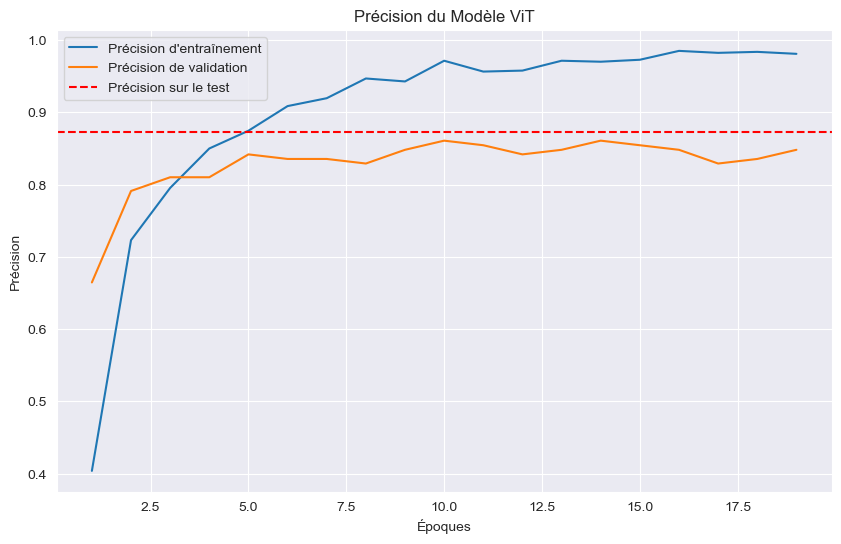

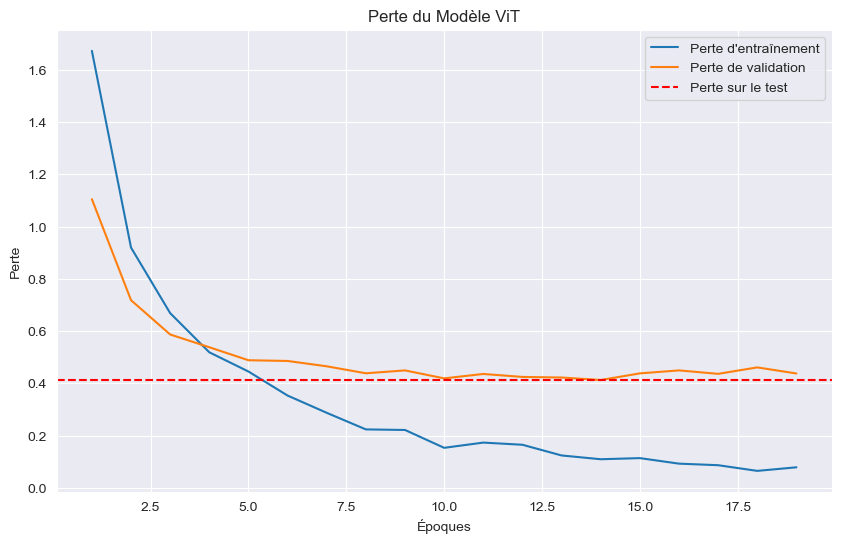

In [79]:
import matplotlib.pyplot as plt
import json
import os

# Chemins pour les fichiers sauvegardés
history_path = os.path.join("..", "model", "vit_model_training_history.json")
test_results_path = os.path.join("..", "model", "vit_model_test_results.json")

# Charger l'historique d'entraînement
if os.path.exists(history_path):
    with open(history_path, "r") as json_file:
        history_vit = json.load(json_file)
else:
    raise FileNotFoundError(f"Fichier d'historique non trouvé : {history_path}")

# Charger les métriques de test
if os.path.exists(test_results_path):
    with open(test_results_path, "r") as json_file:
        test_results_vit = json.load(json_file)
        test_accuracy = test_results_vit.get("test_accuracy")
        test_loss = test_results_vit.get("test_loss")
else:
    test_accuracy = None
    test_loss = None
    print(f"Aucune métrique de test trouvée. Fichier manquant : {test_results_path}")

# Fonction pour tracer les courbes d'entraînement
def plot_history_vit(history_vit, test_accuracy=None, test_loss=None, save_path=None):
    """
    Affiche les courbes de l'historique d'entraînement et de validation pour ViT, 
    et ajoute les métriques de test si disponibles.

    Args:
        history_vit (dict): Historique contenant les pertes et précisions d'entraînement et validation.
        test_accuracy (float): Précision sur l'ensemble de test (optionnel).
        test_loss (float): Perte sur l'ensemble de test (optionnel).
        save_path (str): Chemin pour sauvegarder les graphiques (optionnel).

    Returns:
        None
    """
    # Extraire les données de l'historique
    train_loss = history_vit["train_loss"]
    val_loss = history_vit["val_loss"]
    train_accuracy = history_vit["train_accuracy"]
    val_accuracy = history_vit["val_accuracy"]

    epochs = range(1, len(train_loss) + 1)  # Nombre d'époques

    # Graphique de la précision
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label="Précision d'entraînement")  # Courbe précision entraînement
    plt.plot(epochs, val_accuracy, label="Précision de validation")  # Courbe précision validation

    # Ajouter précision sur le test (si disponible)
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Précision sur le test')  # Ligne précision test

    plt.title("Précision du Modèle ViT")  # Titre du graphique
    plt.xlabel("Époques")  # Étiquette axe des abscisses
    plt.ylabel("Précision")  # Étiquette axe des ordonnées
    plt.legend(loc="best")  # Afficher légende

    # Sauvegarde du graphique précision
    if save_path:
        plt.savefig(f"{save_path}_accuracy_vit.png")
    
    plt.show()  # Affichage du graphique

    # Graphique de la perte
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label="Perte d'entraînement")  # Courbe perte entraînement
    plt.plot(epochs, val_loss, label="Perte de validation")  # Courbe perte validation

    # Ajouter perte sur le test (si disponible)
    if test_loss is not None:
        plt.axhline(y=test_loss, color='r', linestyle='--', label='Perte sur le test')  # Ligne perte test

    plt.title("Perte du Modèle ViT")  # Titre du graphique
    plt.xlabel("Époques")  # Étiquette axe des abscisses
    plt.ylabel("Perte")  # Étiquette axe des ordonnées
    plt.legend(loc="best")  # Afficher légende

    # Sauvegarde du graphique perte
    if save_path:
        plt.savefig(f"{save_path}_loss_vit.png")
    
    plt.show()  # Affichage du graphique

# Chemin pour sauvegarder les graphiques
save_path = os.path.join("..", "model", "vit_model_training_graph")

# Tracer les graphiques
plot_history_vit(
    history_vit,
    test_accuracy=test_accuracy,
    test_loss=test_loss,
    save_path=save_path
)


#### **Observations**

- **Précision :**
  - La précision d'entraînement atteint **98,5%** à la **16ᵉ époque**, montrant une forte convergence.
  - La précision de validation plafonne autour de **86%** dès la **10ᵉ époque**, indiquant une stabilisation.
  - La précision sur le test reste alignée avec la validation, autour de **84%**, indiquant une bonne généralisation.

- **Perte :**
  - La perte d'entraînement diminue constamment jusqu’à **0,09** à la **16ᵉ époque**.
  - La perte de validation atteint son minimum (**0,41**) à la **14ᵉ époque** et fluctue légèrement ensuite.
  - La perte sur le test reste stable autour de **0,42**, cohérente avec la validation.

### **Conclusion**
- Le modèle sauvegardé à la **14ᵉ époque** est optimal.  
- Des ajustements comme l’ajout de régularisation ou une réduction du taux d’apprentissage pourraient améliorer la stabilité.  
- Les performances sont prometteuses, et une évaluation finale sur le jeu de test est recommandée.
## **Observations:**

### **Comparaison des Performances des Modèles:**

In [80]:
import os
import json

# Chemins pour les résultats sauvegardés
vgg_results_path = os.path.join("..", "model", "vgg_model_test_results.json")
vit_results_path = os.path.join("..", "model", "vit_model_test_results.json")

# Charger les résultats du modèle VGG16
if os.path.exists(vgg_results_path):
    with open(vgg_results_path, "r") as json_file:
        vgg_results = json.load(json_file)
        test_loss_vgg = vgg_results.get("test_loss", None)
        test_accuracy_vgg = vgg_results.get("test_accuracy", None)
else:
    raise FileNotFoundError(f"Résultats du modèle VGG16 non trouvés : {vgg_results_path}")

# Charger les résultats du modèle ViT
if os.path.exists(vit_results_path):
    with open(vit_results_path, "r") as json_file:
        vit_results = json.load(json_file)
        test_loss_vit = vit_results.get("test_loss", None)
        test_accuracy_vit = vit_results.get("test_accuracy", None)
else:
    raise FileNotFoundError(f"Résultats du modèle ViT non trouvés : {vit_results_path}")

# Comparaison des performances
print("Comparaison des performances des modèles :\n")

print("VGG16 Model:")
if test_loss_vgg is not None and test_accuracy_vgg is not None:
    print(f"Test Loss: {test_loss_vgg:.4f}")
    print(f"Test Accuracy: {test_accuracy_vgg:.4f}")
else:
    print("Données manquantes pour le modèle VGG16.")

print("\nViT-small Model:")
if test_loss_vit is not None and test_accuracy_vit is not None:
    print(f"Test Loss: {test_loss_vit:.4f}")
    print(f"Test Accuracy: {test_accuracy_vit:.4f}")
else:
    print("Données manquantes pour le modèle ViT.")


Comparaison des performances des modèles :

VGG16 Model:
Test Loss: 0.6402
Test Accuracy: 0.7595

ViT-small Model:
Test Loss: 0.4131
Test Accuracy: 0.8734


### Observations :
Le modèle **ViT-small** surpasse clairement le modèle **VGG16** en termes de précision et de perte sur le test, confirmant une meilleure capacité de généralisation et de performance globale.

### Synthèse des performances des modèles VGG16 et ViT-small:

In [81]:
import pandas as pd
import os
import json

# Chemins pour les fichiers sauvegardés
vgg_history_path = os.path.join("..", "model", "vgg_model_training_history.json")
vit_history_path = os.path.join("..", "model", "vit_model_training_history.json")
vgg_test_results_path = os.path.join("..", "model", "vgg_model_test_results.json")
vit_test_results_path = os.path.join("..", "model", "vit_model_test_results.json")

# Charger les historiques d'entraînement
if os.path.exists(vgg_history_path):
    with open(vgg_history_path, "r") as json_file:
        history_vgg16 = json.load(json_file)
else:
    raise FileNotFoundError(f"Fichier d'historique VGG16 non trouvé : {vgg_history_path}")

if os.path.exists(vit_history_path):
    with open(vit_history_path, "r") as json_file:
        history_vit = json.load(json_file)
else:
    raise FileNotFoundError(f"Fichier d'historique ViT non trouvé : {vit_history_path}")

# Charger les résultats de test
if os.path.exists(vgg_test_results_path):
    with open(vgg_test_results_path, "r") as json_file:
        test_results_vgg16 = json.load(json_file)
        test_accuracy_vgg16 = test_results_vgg16.get("test_accuracy", None)
else:
    raise FileNotFoundError(f"Résultats de test VGG16 non trouvés : {vgg_test_results_path}")

if os.path.exists(vit_test_results_path):
    with open(vit_test_results_path, "r") as json_file:
        test_results_vit = json.load(json_file)
        test_accuracy_vit = test_results_vit.get("test_accuracy", None)
else:
    raise FileNotFoundError(f"Résultats de test ViT non trouvés : {vit_test_results_path}")

# Vérifier que les historiques contiennent des données valides
if not history_vgg16.get("train_accuracy") or not history_vit.get("train_accuracy"):
    raise ValueError("Les historiques d'entraînement ne contiennent pas les métriques nécessaires.")

# Extraire les métriques finales pour VGG16
accuracy_train_vgg16 = history_vgg16["train_accuracy"][-1]
accuracy_val_vgg16 = history_vgg16["val_accuracy"][-1]
accuracy_test_vgg16 = test_accuracy_vgg16

# Extraire les métriques finales pour ViT-base
accuracy_train_vit = history_vit["train_accuracy"][-1]
accuracy_val_vit = history_vit["val_accuracy"][-1]
accuracy_test_vit = test_accuracy_vit

# Définir les noms des modèles
model_names = ['VGG16', 'ViT-base']

# Créer les listes pour chaque métrique
accuracy_train = [accuracy_train_vgg16, accuracy_train_vit]
accuracy_val = [accuracy_val_vgg16, accuracy_val_vit]
accuracy_test = [accuracy_test_vgg16, accuracy_test_vit]

# Créer le DataFrame
df_synthese = pd.DataFrame({
    'Model': model_names,
    'Accuracy (Train)': accuracy_train,
    'Accuracy (Validation)': accuracy_val,
    'Accuracy (Test)': accuracy_test
})

# Afficher le tableau de synthèse
print(df_synthese)

# Sauvegarder le tableau en CSV dans le dossier `model`
synthese_csv_path = os.path.join("..", "model", "synthese_modeles_vgg16_vs_vit.csv")
df_synthese.to_csv(synthese_csv_path, index=False)
print(f"Tableau de synthèse sauvegardé dans : {synthese_csv_path}")


      Model  Accuracy (Train)  Accuracy (Validation)  Accuracy (Test)
0     VGG16          0.836289               0.822785         0.759494
1  ViT-base          0.980900               0.848101         0.873418
Tableau de synthèse sauvegardé dans : ..\model\synthese_modeles_vgg16_vs_vit.csv


### **Observations**

- **VGG16 :**
  - Précision d'entraînement : **83,63 %**
  - Précision de validation : **82,28 %**
  - Précision sur le test : **75,95 %**
  - Conclusion : Performances correctes mais limitées, avec une légère baisse de précision entre la validation et le test.

- **ViT-base :**
  - Précision d'entraînement : **98,09 %**
  - Précision de validation : **84,81 %**
  - Précision sur le test : **87,34 %**
  - Conclusion : Meilleure généralisation et précision globale par rapport à VGG16, avec des écarts limités entre les phases.

### **Résumé**
Le modèle **ViT-base** surpasse largement le modèle **VGG16** en termes de précision sur l'ensemble de test, confirmant une meilleure capacité de généralisation.
